# Metrics III: GMM and SMM
## Homework 3
Chengzi Yi, 08/03/2022

This code is a sample code prepared for homework 3 of Metrics III/GMM&SMM
taught by Prof. Russell Cooper at the EUI.

If you have any comments or suggestions, please contact Chengzi.Yi@eui.eu.


### Part 1: Revenue Function Estimation
* process the panel data in Stata

In [3]:
import delimited using "homework_2022/hw3_data/revfunc_data.csv", clear
* OLS: logy = cons + α*logk + residul(logA)
* true α=0.6
gen logpi = log(output)
gen logk = log(capital)
reg logpi logk
local alpha_ols = e(b)[1,1]

* Quasi-differenicng
xtset firm_id year
reg logpi L.logpi logk L.logk
local alpha_qd = e(b)[1,2] //coefficient on logk
di "Estimated alpha in OLS:" `alpha_ols'
di "Estimated alpha in Quasi-Difference-Equation:" `alpha_qd'

* GMM





(encoding automatically selected: ISO-8859-1)
(4 vars, 150,000 obs)




      Source |       SS           df       MS      Number of obs   =   150,000
-------------+----------------------------------   F(1, 149998)    >  99999.00
       Model |  14762.7574         1  14762.7574   Prob > F        =    0.0000
    Residual |  3255.08826   149,998  .021700878   R-squared       =    0.8193
-------------+----------------------------------   Adj R-squared   =    0.8193
       Total |  18017.8457   149,999  .120119772   Root MSE        =    .14731

------------------------------------------------------------------------------
       logpi | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
        logk |   .6607087   .0008011   824.79   0.000     .6591387    .6622788
       _cons |    .174825   .0007862   222.37   0.000     .1732841    .1763659
---------------------------------------------------------

### Part 2: Machine Replacement Problem

In [2]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from quantecon.markov.approximation import tauchen
from numba import typeof, jit, njit, prange, float64, int64



OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# data moments: you can also get the data moments from stata or R
    # load the dataset
dataset = pd.read_csv("homework_2022/hw3_data/mrp_data.csv")
    # you need age and replacement decision to compute the data moments
dt_rep = pd.DataFrame(dataset, columns=['age','replace']).to_numpy() # two columns
dt_age = dt_rep[:,0] # the first column is the observation of age
max_age = max(dt_age) # the oldest machine in the observation

mm_dt = np.ones(30)
for age in range(int(max_age)+1):
    # for a specific age, compute the fraction of firms replaced their machine
    n_plant = dt_rep[dt_age==age,:].shape[0] #how many observations/plants
    n_rep = dt_rep[dt_age==age,:][:,1].sum() #how many replacement
    mm_dt[age] = n_rep / n_plant #prob. computed by counting

print(mm_dt)


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03967798 0.10841232 0.26037483
 0.26709797 0.34193548 0.46121593 0.48333333 0.65289256 1.
 1.         1.         1.         1.         1.         1.        ]


In [5]:
// deal with panel data in stata
import delimited using "homework_2022/hw3_data/mrp_data.csv", clear
local delta = 0.01
local alpha = 0.8
gen capital = (1 - `delta') ^ age
gen logA = log(output / (capital) ^ `alpha')
qui xtset firm_id year
qui reg logA L.logA, nocons
               
//mat list e(b)
local rho = e(b)[1,1]
local sigma = e(rmse)
di "estimated rho_a:" `rho'
di "estimated sigma_a:" `sigma'


(encoding automatically selected: ISO-8859-1)
(5 vars, 30,000 obs)









estimated rho_a:.940643

estimated sigma_a:.04998534


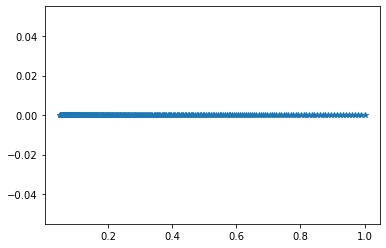

In [4]:
# solve the model
# parameters you already know
α = 0.8 #elasticity of revenue to capital
δ = 0.01 #depreciation rate

# estimation outside the dynamic optimization
# discretization
    #state space is (1, (1-δ), (1-δ)^2, ...,)
nkk = 300
k_grid = np.empty(nkk)
for i in range(nkk):
    k_grid[i] = (1 - δ) ** i

plt.plot(k_grid, np.zeros_like(k_grid),  "*")

# estimate the profitability process, by OLS, see the stata code;
#dataset['capital'] = (1 - δ) ** dataset['age']
#dataset['logA'] = np.log(dataset['output'] / (dataset['capital'] ** α))

ρ_hat = .940643
σ_hat = .04998534
naa = 20
mc_A = tauchen(ρ_hat, σ_hat, m=2, n=naa)
A_array, PA = mc_A.state_values, mc_A.P
A_array = np.exp(A_array)

# parameters that you need to estimate in the model
β_g = 0.9 #discount factor
F_g = 0.7 #fixed adjustment cost


In [5]:
# functions
@njit
def r_func(A, k):
    return A * k ** α

#VFI
@njit(parallel=True)
def T(v, β, F):
    Tv = np.zeros_like(v)
    pol = np.zeros_like(v, dtype=np.int8)
    for iA in prange(naa):
        for ik in prange(nkk):
            k, A = k_grid[ik], A_array[iA]
            # if replace the machine
            v_r = r_func(A, k) - F + β * (PA[iA,:] @ v[:,0])
            # if keep the machine
            if ik == nkk-1: #keep the oldest one at its old age
                v_k = r_func(A, k) + β * (PA[iA,:] @ v[:,ik])
            else:
                v_k = r_func(A, k) + β * (PA[iA,:] @ v[:,ik+1])
            Tv[iA,ik] = np.amax(np.array([v_r, v_k]))
            pol[iA, ik] = (v_r > v_k)
    return Tv, pol

@njit
def VFI(v0, β, F, tol=1e-6, max_iter=1000):
    error = 1
    it = 0
    v = v0
    while error > tol and it < max_iter:
        vnew, polnew = T(v, β, F)
        error = np.amax(np.abs(vnew - v))
        v = vnew
        it += 1
    return vnew, polnew


Text(0, 0.5, '$V$')

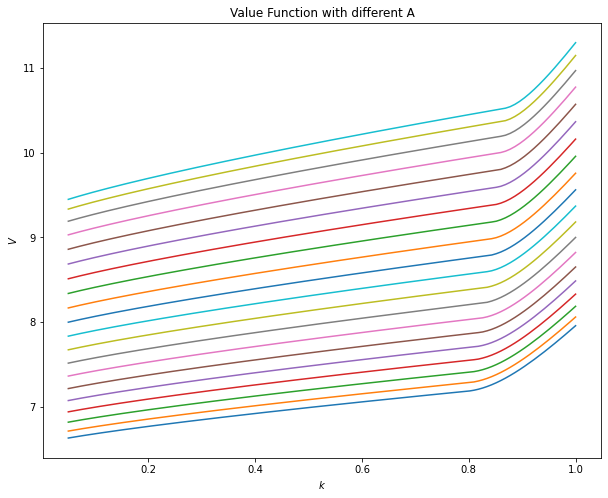

In [6]:
# solve the problem
    # initial guess
v0 = np.empty((naa, nkk), order="F")
for iA, A in enumerate(A_array):
    for ik, k in enumerate(k_grid):
        v0[iA, ik] = (r_func(A, k)) / (1 - β_g)
    # solve the problem by vfi
v_star_g, pol_star_g = VFI(v0, β_g, F_g)
    # drop the last dimenstion of k because it's not iterated over
v_star_g, pol_star_g = v_star_g[:,0:-1], pol_star_g[:,0:-1]
k_grid1 = k_grid[:-1]
pol_star_g[:,0]
    # plot the value functions
fig_vf, ax = plt.subplots(figsize=(10,8))
for iA in range(naa):
    ax.plot(np.flip(k_grid1),np.flip(v_star_g[iA,:]))
ax.set_title("Value Function with different A")
ax.set_xlabel("$k$")
ax.set_ylabel("$V$")


# SMM


In [7]:
# simulated moments
def _sim_data_f(pol_star, A_series, t_length):
    """
    simulate the data for a firm; we need age and replacement

    * pol_star: replacement decision
    * A_series: realization of idiosyncratic shocks
    """
    vt_series = np.empty(t_length) #age
    rep_series = np.empty(t_length, dtype=np.int8) #replacement decision

    ik = 0 #when t=0, start with k=1
    for t in range(t_length):
        iA = A_series[t] #from t=1 to t=T
        pol_r = pol_star[iA,ik]
        vt_series[t] = ik #vintage
        if pol_r == False:
            ik += 1
        elif pol_r == True:
            ik = 0

        rep_series[t] = pol_r

    return vt_series, rep_series

def sim_data_panel(pol_star, mc_A, seed, N=10_00, T=500):
    """
    simulate the panel data of N firms for T periods;
    given policy function of replacement;
    allow for burning periods of 50 periods

    * pol_star: replacement decision
    * mc_A: markov chain that represents A process
    """
    burning = 50
    A_sim = mc_A.simulate_indices(T+burning, num_reps=N, random_state=seed) # matrix of dimension(N×T)
    vt_sim = np.empty((N, T+burning))
    rep_sim = np.empty_like(vt_sim, dtype=np.int8)
    for i in range(N): #for every firm
        vt_sim[i,:], rep_sim[i,:] = \
            _sim_data_f(pol_star, A_sim[i,:], t_length=T+burning)

    #throw away the burning periods
    return vt_sim[:,-T:], rep_sim[:,-T:]

def sim_moments(β0, F0, N, T, seed):
    "mapping from parameters to simulated moments"
    # given β and F, solve the DGP; A process is as estimated
    v0 = np.ones((naa, nkk), order="F")
        # solve the problem by vfi
    v_star, pol_star = VFI(v0, β0, F0)
        # drop the last k (smallest k) because it's not iterated over
    v_star, pol_star = v_star[:,0:-1], pol_star[:,0:-1]

    # simulate the panel
    vt_sim, rep_sim = sim_data_panel(pol_star, mc_A, seed, N, T) #(N×T)
    sim_age = vt_sim.flatten()
    sim_rep = np.vstack((sim_age, rep_sim.flatten())).T

    # obtain simulated moments
    max_age = np.amax(vt_sim) #the oldest machine in the observation
    mm_sim = np.ones(30)
    for age in range(np.fmin(int(max_age)+1, 30)):
        n_plants = sim_rep[sim_age==age,:].shape[0]
        n_reps = sim_rep[sim_age==age,:][:,1].sum()
        mm_sim[age] = n_reps / (n_plants)

    return mm_sim

def Jfunc(params, W, N, T, seed=4321):
    """
    criterion function that need to be minimized.
    set seed, so for each guess of β and F, we are using the same simulated shock.

    * params: (β, F), as a list of arguments to pass in function sim_moments
    * W: weighting matrix
    * T: simulated sample size
    """
    mm_sim = sim_moments(*params, N, T, seed)

    return (mm_sim - mm_dt) @ W @ (mm_sim - mm_dt)


Text(0.5, 0, 'criterion function')

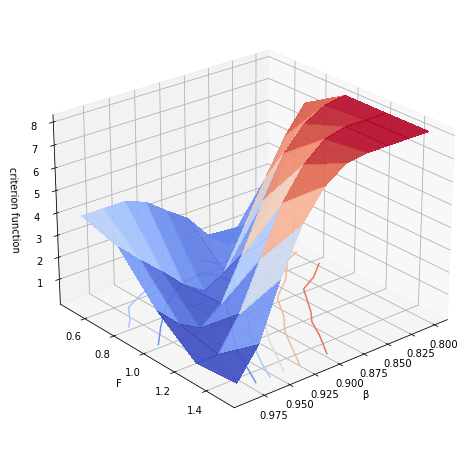

In [8]:
# estimate β and F
#W_mat = np.eye(mm_dt.size)
W_mat = np.diag(mm_dt > 0) #let's only use information when prob(replacement) > 0 in the data
N_sim = 1000
T_sim = 100

# plot the criterion function
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

β_array = np.linspace(0.80, 0.99, 10)
F_array = np.linspace(0.5, 1.5, 5)
J_array = np.zeros((10, 5))
for i in range(10):
    for j in range(5):
        params = (β_array[i], F_array[j])
        J_array[i,j] = Jfunc(params, W_mat, N_sim, 100)

bb, ff = np.meshgrid(β_array, F_array)

fig_J, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
ax.plot_surface(bb, ff, J_array.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.9)
ax.contour(bb, ff, J_array.T, zdir='z', offset=0, cmap=cm.coolwarm)
ax.view_init(25, 50)
ax.set_xlabel('β')
ax.set_ylabel('F')
ax.set_zlabel('criterion function')

In [9]:
# minimization
x0 = (0.92, 1.1)
bnds = ((0.875, 0.99), (0.8, 1.5)) #bounds for β and F
tol = 1e-5
opt={'maxiter': 10_00, 'disp': False}
params_ssm = optimize.minimize(Jfunc, x0, args=(W_mat, N_sim, T_sim), method='Powell',
                               bounds=bnds, options=opt, tol=tol)

print(f"The estimate of β and F are {params_ssm.x[0]:.4f} and {params_ssm.x[1]:.4f}, respectively.")

The estimate of β and F are 0.9611 and 1.0915, respectively.
